In [1]:
import zipfile, os, shutil,re
from os.path import isfile, isdir
from matplotlib import pyplot as plt
# import time
import random
import numpy as np
# import h5py
import pandas as pd
import cv2
# from tqdm import tqdm
import keras
from keras import regularizers
from keras.applications import *
from keras.models import Model
from keras.layers import Activation, Dropout, Flatten, Dense,Input,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger,ReduceLROnPlateau
from keras.models import load_model

import tensorflow as tf

# train image number 25,000 , test image number 12,500 , set batch_size = 25
batch_size = 50
epochs = 20

# extract train image to folder 'train' and 'test'
train_path = 'train'
test_path = 'test'
# extract train
if not isdir(train_path):
    zipFile = zipfile.ZipFile('train.zip')
    zipFile.extractall()
    zipFile.close()
    
# move cat's image to folder 'train/cat/', dog's image to folder 'train/dog'
if not isdir('train/cat'):
    os.mkdir('train/cat')
if not isdir('train/dog'):
    os.mkdir('train/dog')
    
for filename in os.listdir('train'):
    match_obj1 = re.search(r'cat.[0-9]*.jpg',filename)
    if match_obj1:
        shutil.move('train/'+filename, 'train/cat/')
    
    match_obj2 = re.search(r'dog.[0-9]*.jpg',filename)
    if match_obj2:
        shutil.move('train/'+filename, 'train/dog/'+filename)
        
# extract test image to folder 'test'
if not isdir('test'):
    zipFile = zipfile.ZipFile('test.zip')
    zipFile.extractall()
    zipFile.close()
    os.mkdir('test/test')
    for file in os.listdir('test'):
        if not os.path.isdir(file):
            shutil.move('test/'+file,'test/test/')

C:\Users\thomas_gui\AppData\Local\conda\conda\envs\py36\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# define random_transfer function
# used these functions for data argumentation

def random_crop(img, ratio=1.0):
    #随机剪裁, Ratio是裁剪后与裁剪前的面积比
    if random.random() < 1:
        h,w = img.shape[:2]
        #长宽比随机扰动变量 hw_delta
        hw_delta = np.random.uniform(-0.05,0.05)
        hw_mult = 1 + hw_delta
        
        w_crop = int(round(w*np.sqrt(ratio*hw_mult)))
        
        if w_crop > w:
            w_crop = w
        
        h_crop = int(round(h*np.sqrt(ratio/hw_mult)))
        if h_crop > h:
            h_crop = h
        
        x0 = np.random.randint(0,w-w_crop+1)
        y0 = np.random.randint(0,h-h_crop+1)
        
        img = img[y0:y0+h_crop,x0:x0+w_crop]
        
    return img
    
def random_rotate(img, angle=0.0):
    if random.random() < 1:
        h,w = img.shape[:2]
        angle = np.random.choice([-angle,angle])
        # angle cycle is 360
        angle %= 360
        # 用openCV 内置函数计算仿射矩阵
        M_rotate = cv2.getRotationMatrix2D((w/2,h/2),angle,1)
        # 得到旋转后的图片
        img = cv2.warpAffine(img, M_rotate, (w, h))
        
        angle_crop = angle % 180
        
        if angle_crop > 90:
            angle_crop = 180 - angle_crop
        # convert to rad
        theta = angle_crop * np.pi / 180.0
        # compute high width ratio
        hw_ratio = float(h) / float(w)
        
        tan_theta = np.tan(theta)
        numerator = np.cos(theta) + np.sin(theta) * tan_theta
        
        # 计算分母项中的宽高比相关的项
        r = hw_ratio if h > w else 1/hw_ratio
        # 计算分母项
        denominator = r * tan_theta +1
        # 计算最终边长系数
        crop_mult = numerator / denominator
        # 得到剪裁区域
        w_crop = int(round(crop_mult*w))
        h_crop = int(round(crop_mult*h))
        x0 = int((w-w_crop)/2)
        y0 = int((h-h_crop)/2)
        img = img[y0:y0+h_crop,x0:x0+w_crop]
        
    return img

def random_shear(img,angle=0.0):
    if random.random() < 1:
        h,w = img.shape[:2]
        #产生随机剪切角度值
        angle = np.random.choice([-angle,angle])
        # x轴剪切变换，角度值=angle
        theta = angle * np.pi / 180
        M_shear = np.array([[1,np.tan(theta), 0],[0,1,0]],dtype = np.float32)
        img = cv2.warpAffine(img, M_shear, (w, h))
    return img

def random_h_flip(img, horizontal_flip=False):
    if horizontal_flip == True:
        if random.random() < 1:
            img = cv2.flip(img, 1)
    return img
            
def random_v_flip(img, vertical_flip=False):
    if vertical_flip == True:
        if random.random() < 1:
            img = cv2.flip(img,0)
    return img    

def random_transfer(img, ratio=None,rotate=None,shear=None,
                  horizontal_flip=False,vertical_flip=False):
    params = {}
    if ratio is not None:
        params['ratio'] = ratio
    if rotate is not None:
        params['rotate'] = rotate
    if shear is not None:
        params['shear'] = shear
    if horizontal_flip:
        params['horizontal_flip'] = horizontal_flip
    if vertical_flip:
        params['vertical_flip'] = vertical_flip
        
    if params:
        func = []
        for param in params.keys():
            func.append(param)
    func = random.choice(func)
    # print('function, params:\n',func,params[func])
    
    function_map = { 'ratio':random_crop,
                     'rotate':random_rotate,
                     'shear':random_shear,
                     'horizontal_flip':random_h_flip,
                     'vertical_flip':random_v_flip
                    }
    
    img_transfer = function_map[func](img,params[func])
    return img_transfer

In [3]:
# remove outliers of train set
cat_outlier = ['cat.3216.jpg', 'cat.3672.jpg', 'cat.3731.jpg', 'cat.3822.jpg', 'cat.4085.jpg', 'cat.4190.jpg', 'cat.4338.jpg',
               'cat.4688.jpg', 'cat.5351.jpg', 'cat.6277.jpg', 'cat.6402.jpg', 'cat.6649.jpg', 'cat.6840.jpg', 'cat.7377.jpg', 
               'cat.7564.jpg', 'cat.8100.jpg', 'Cat.8272.jpg', 'cat.8456.jpg', 'cat.9171.jpg', 'cat.9513.jpg', 'cat.9770.jpg', 
               'cat.10029.jpg', 'cat.10539.jpg', 'cat.10625.jpg', 'cat.10827.jpg', 'cat.10946.jpg', 'cat.11184.jpg', 
               'cat.12272.jpg', 'cat.12493.jpg', 'cat.12499.jpg']
dog_outlier = ['dog.1043.jpg', 'dog.1094.jpg', 'dog.1259.jpg', 'dog.1308.jpg', 'dog.1835.jpg', 'dog.1895.jpg', 'dog.2877.jpg',
               'dog.3074.jpg','dog.4367.jpg', 'dog.4507.jpg', 'dog.4872.jpg', 'dog.5490.jpg', 'dog.5604.jpg', 'dog.6272.jpg', 
               'dog.6405.jpg', 'dog.6725.jpg', 'dog.7076.jpg', 'dog.7798.jpg', 'dog.7913.jpg', 'dog.8736.jpg', 'dog.9188.jpg', 
               'dog.9517.jpg', 'dog.10190.jpg', 'dog.10237.jpg','dog.10747.jpg','dog.10797.jpg', 'dog.11186.jpg', 
               'dog.11299.jpg', 'dog.12331.jpg', 'dog.12376.jpg']

# print(len(cat_outlier))
# print(len(dog_outlier))
for i in range(30):
    if os.path.isfile('train/cat/'+cat_outlier[i]):
        os.remove('train/cat/'+cat_outlier[i])
    if os.path.isfile('train/dog/'+dog_outlier[i]):
        os.remove('train/dog/'+dog_outlier[i])

cat_list = os.listdir('train/cat')
dog_list = os.listdir('train/dog')

In [4]:
# random choose a existing image, excute random transfer, replace each outlier image
for i in range(30):
    cat_file = random.choice(cat_list)
    img_cat = cv2.imread('train/cat/'+cat_file)
    img_cat = random_transfer(img_cat, 0.9,10,10,True,True)
    cv2.imwrite('train/cat/'+cat_outlier[i],img_cat)
    
    dog_file = random.choice(dog_list)
    img_dog = cv2.imread('train/dog/'+dog_file)
    img_dog = random_transfer(img_dog, 0.9,10,10,True,True)
    cv2.imwrite('train/dog/'+dog_outlier[i],img_dog)

In [3]:
X_catfile = ['train/cat/cat.%d.jpg' % i for i in range(12500)]
X_dogfile = ['train/dog/dog.%d.jpg' % i for i in range(12500)]
# set the validation split = 0.2
# then split train_set into X_train,X_val, y_train, y_val
splitpoint = int(12500 * 0.8)
# to keep cat and dog file samples balance in train, validation set.
# split 10,000 cat file list into train, 2,500 cat file list into validation
X_catfile_train,X_catfile_val = X_catfile[:splitpoint],X_catfile[splitpoint:]
# split 10,000 dog file list into train, 2,500 dog file list into validation
X_dogfile_train,X_dogfile_val = X_dogfile[:splitpoint],X_dogfile[splitpoint:]
# merge cat and dog train set, total 20,000 file list, first 10,000 is cat file, next 10,000 is dog file
X_train = np.array(X_catfile_train + X_dogfile_train)
# generate train label, first 10,000 is cat file, label = 0 , then next 10,000 label = 1

y_train = np.array([0 for i in range(splitpoint)] + [1 for i in range(splitpoint)])
# same as above operation, merge cat cat and dog validation set, then generate validation label
X_val = np.array(X_catfile_val + X_dogfile_val)
y_val = np.array([0 for i in range(splitpoint,12500)] + [1 for i in range(splitpoint,12500)])

# shuffle train & validation set
# set index for train and validation set
train_idx = np.arange(20000)
val_idx = np.arange(5000)
# set random seed to make sure shuffle result not change everytime
random.seed(2018)
# shuffle train index
random.shuffle(train_idx)

random.seed(2018)
# shuffle validation index
random.shuffle(val_idx)
# re-arrange X_train,y_train by shuffled index
X_train,y_train = X_train[train_idx],y_train[train_idx]
X_val,y_val = X_val[val_idx],y_val[val_idx]
#print(y_train.sum())    #half sample list is cat，another one is dog, so train label sum = 10,000

In [4]:
from keras.applications.inception_v3 import preprocess_input as inception_input
from keras.applications.resnet50 import preprocess_input as resnet_input

# generator for train set
def train_generator(X=None, y=None, batch_size=32,ratio=None,rotate=None,shear=None,
                  horizontal_flip=False,vertical_flip=False): 
        
    datalen = len(y)
    counter = datalen//batch_size
    
    while (True):
        # index = np.arange(datalen)
        # random.seed(2018)
        # random.shuffle(index)
        # X = X[index]
        # y = y[index]
        for i in range(counter):
            # each batch, initialize 2 numpy array with 0 value,type of float64
            # 299 x 299 input pixel for InceptionV3, Xception; 224 x 224 input pixel for Resnet ResNet50
            X_299 = np.zeros((batch_size,299,299,3),dtype=np.float)
            X_224 = np.zeros((batch_size,224,224,3),dtype=np.float)
            for j in range(batch_size):
                # load picture by filename,convert to numpy array
                img = cv2.imread(X[i*batch_size+j])
                # data augmentation, random choose a transfer method
                img = random_transfer(img, ratio,rotate,shear,
                                horizontal_flip,vertical_flip)
                # resize to 299 x 299 pixel
                X_299[j] = cv2.resize(img,(299,299))
                # resize to 224 x 224
                X_224[j] = cv2.resize(img,(224,224))
            
            # preprocess input for InceptionV3, Xception    
            X_299 = inception_input(X_299)
            # preprocess input for ResNet50
            X_224 = resnet_input(X_224)
            
            # generate each batch input list including input1(299x299), input2(224x224) for training and label
            yield [X_299,X_224], y[i* batch_size:(i + 1) * batch_size]

# generator for validation set
def val_generator(X=None, y=None, batch_size=32):
    
    datalen = len(y)
    counter = datalen//batch_size   
        
    while (True):
        for i in range(counter):
            X_299 = np.zeros((batch_size,299,299,3),dtype=np.float)
            X_224 = np.zeros((batch_size,224,224,3),dtype=np.float)
            for j in range(batch_size):
                X_299[j] = cv2.resize(cv2.imread(X[i* batch_size+j]),(299,299))
                X_224[j] = cv2.resize(cv2.imread(X[i* batch_size+j]),(224,224))
            X_299 = inception_input(X_299)
            X_224 = resnet_input(X_224)
            yield [X_299,X_224], y[i * batch_size:(i + 1) * batch_size]
            

In [5]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#from keras.utils import plot_model

inception_V3 = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (299, 299,3),pooling='avg')
for layer in inception_V3.layers:
    layer.trainable = False

xception = Xception(include_top= False, weights='imagenet',input_shape=(299,299,3),pooling='avg')
for layer in xception.layers:
    layer.trainable = False
    
resnet50 = ResNet50(include_top= False, weights='imagenet',input_shape=(224,224,3),pooling='avg')
for layer in resnet50.layers:
    layer.trainable = False

input1 = Input((299,299,3))
input2 = Input((224,224,3))

x1 = inception_V3(input1)
x2 = xception(input1)
x3 = resnet50(input2)
# merge InceptionV3, Xception, ResNet50 transfer model features
x = keras.layers.concatenate([x1,x2,x3])

x = Dropout(0.5)(x)
x = Dense(1,activation = 'sigmoid')(x)
tune_model = Model(inputs=[input1,input2],outputs=x)

tune_model.compile(loss = 'binary_crossentropy', optimizer ='Adam', metrics =['accuracy'])
#plot_model(tune_model, to_file='model_add_BN.png',show_shapes = True) 
#SVG(model_to_dot(tune_model).create(prog='dot', format='svg'))
tune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 2048)         21802784    input_4[0][0]                    
__________________________________________________________________________________________________
xception (Model)                (None, 2048)         20861480    input_4[0][0]                    
__________________________________________________________________________________________________
resnet50 (

In [6]:
# in case, computer crash in a specified epoch, save checkpointer of model
# restore a previous model to continue traing from the specified epoch.
# tune_model = load_model('./model/tune_model.h5')
if not isdir('model'):
    os.mkdir('model')
checkpointer = ModelCheckpoint('./model/tune_model_V5.h5', monitor='val_loss', verbose=0, save_best_only=True, 
                                save_weights_only=False, mode='auto', period=1)

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

logger = CSVLogger('./model/log_V5.csv', separator=',', append=True)

# if restore previous model, may train from specified epoch by parameters "initial_epoch= "
model_history = tune_model.fit_generator(train_generator(X_train, y_train, batch_size,0.9,20,20,True,True),
                                         steps_per_epoch=len(y_train)//batch_size, epochs=epochs,
                                         validation_data = val_generator(X_val, y_val, batch_size),
                                         validation_steps=len(y_val)//batch_size,
                                         callbacks = [earlystop,checkpointer,logger],
                                         verbose=1)

Epoch 1/20
400/400 [==============================] - 775s 2s/step - loss: 0.1488 - acc: 0.9404 - val_loss: 0.0300 - val_acc: 0.9892
Epoch 2/20
400/400 [==============================] - 767s 2s/step - loss: 0.1004 - acc: 0.9612 - val_loss: 0.0502 - val_acc: 0.9848
Epoch 3/20
400/400 [==============================] - 763s 2s/step - loss: 0.0970 - acc: 0.9627 - val_loss: 0.0417 - val_acc: 0.9878
Epoch 4/20
400/400 [==============================] - 766s 2s/step - loss: 0.0936 - acc: 0.9638 - val_loss: 0.0416 - val_acc: 0.9884
Epoch 5/20
400/400 [==============================] - 776s 2s/step - loss: 0.0894 - acc: 0.9658 - val_loss: 0.0476 - val_acc: 0.9874
Epoch 6/20
400/400 [==============================] - 775s 2s/step - loss: 0.0889 - acc: 0.9644 - val_loss: 0.0397 - val_acc: 0.9894


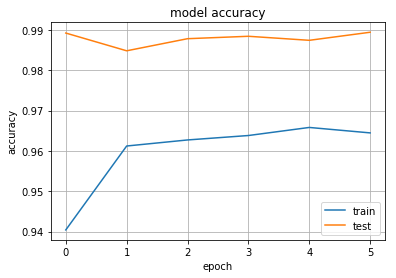

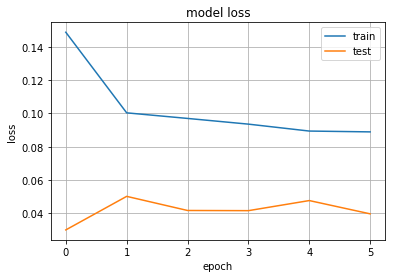

In [8]:
# summarize history for accuracy
plt.plot(model_history.history['acc'])  
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='lower right')  
plt.show()  
# summarize history for loss  
plt.plot(model_history.history['loss'])  
plt.plot(model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='upper right')  
plt.show()  

In [7]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator()
test_299 = test_datagen.flow_from_directory(
        'test/',
        target_size=(299, 299),
        batch_size=50,
        shuffle = False,
        class_mode=None)
test_224 = test_datagen.flow_from_directory(
        'test/',
        target_size=(224, 224),
        batch_size=50,
        shuffle = False,
        class_mode=None)

def test_generator():
    while (True):
        X_299 = test_299.next()
        X_224 = test_224.next()
        
        X_299 = inception_input(X_299)
        X_224 = resnet_input(X_224) 
        yield [X_299,X_224]

predictions = tune_model.predict_generator(test_generator(),steps = 250, verbose =1)
predictions = predictions.clip(min=0.005,max=0.995)

output = pd.read_csv('sample_submission.csv')
for i,filename in enumerate(test_299.filenames):
    # find digit section in filename,then convert to integer index of test picture filename
    index = int(filename[filename.rfind('\\') + 1 : filename.rfind('.')])
    # test filename from 1 - 12500, but csv index from 0 - 12499, so in csv index equals filename index -1
    # set the corresponding label by index
    output.loc[index-1 ,'label'] = predictions[i]
    
output.to_csv('predictions_merge_V5.csv',index=None)

Found 12500 images belonging to 1 classes.
Found 12500 images belonging to 1 classes.
250/250 [==============================] - 425s 2s/step
